##Предсказание загрязненности воды

Набор данный представляет выборку оценок степени загрязнённости воды в Европейских странах за период между 1991 и 2017 годами. Кроме оценок самого целевого показателя (загрязненность) набор содержит ряд первичных данных, например, содержание пластика, географическое место измерений, число туристов и т.д.

Цель этого набора данных - построить модель предсказания оценок загрязненности воды по первичным показателям.

Ссылка на соревнование: 
https://www.kaggle.com/competitions/urfu-engai-ml-2022-classification/overview

# 1. Подготовка: импорт библиотек и классов, загрузка токена и датафреймов.

Импортируем следующие библиотеки:


1.   files для загрузки файлов (конфиг каггла, в нашем случае);
2.   pandas для работы с данными;
3. numpy для мат. вычислений;
4.   seaborn для визуального отображения данных;
5.   train_test_split для разбиения данных на валидационные и тренировочные;
6. GridSearchCV для автоматического подбора оптимальных значений гиперпараметров модели;
5.   модель SGDCLassifier;
6.   preprocessing для нормализации цифровых значений;
7.   mean_squared_error для определения среднеквадратической ошибки;
8.   math для вычислительных операций.

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.metrics import f1_score
import math

Загружаем кабачок:

In [2]:
KABACHOK = files.upload()

Saving kaggle.json to kaggle.json


Bash-команды ниже выполняют следующее:

1.   Создаём приватную дирректорию и помещаем в неё наш json-конфиг и меняем права доступа (для владельца - чтение и запись, для остальных - ничего);
2.   Загружаем zip-архив с данными для соревнования;
3.   Разархивируем архив;
2.   Удаляем архив, чтобы не занимать лишнюю память.

In [3]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c urfu-engai-ml-2022-classification
!unzip urfu-engai-ml-2022-classification.zip
!rm /content/urfu-engai-ml-2022-classification.zip

  0% 0.00/45.2k [00:00<?, ?B/s]
100% 45.2k/45.2k [00:00<00:00, 21.0MB/s]
Archive:  urfu-engai-ml-2022-classification.zip
  inflating: Submission.csv          
  inflating: Target.csv              
  inflating: Test.csv                
  inflating: Train.csv               


Читаем датафреймы:

In [4]:
trainDF = pd.read_csv(
    '/content/Train.csv', 
    delimiter = ',', 
    index_col = 0
)

testDF = pd.read_csv(
    '/content/Test.csv', 
    delimiter = ',', 
    index_col = 0
)

target = pd.read_csv(
    '/content/Target.csv', 
    delimiter = ',', 
    index_col = 0
)


submission = pd.read_csv(
    '/content/Submission.csv',
    delimiter = ',',
    index_col = 0
)

# 2. Предварительная обработка данных: нормализация и кодировка категориальных данных.

Объединяем тренировочные и тестовые датафреймы для одновременной обработки данных:

In [162]:
concated = pd.concat([trainDF, testDF])
concated

,code,year,period,id,Country,tourists,venue,rate,food,glass,metal,other,paper,plastic,leather,green_waste,waste_recycling
11,EEA_3161-03-3,2009,2009-04--2009-10,FRGR0220,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
20,EEA_3161-05-5,2009,2009-01--2009-12,FRDR179,France,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
27,EEA_3161-01-1,2009,2009-01--2009-12,FRDR174,France,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
28,EEA_3161-05-5,2009,2009-01--2009-12,FRDR174,France,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
33,EEA_3161-03-3,2009,2009-01--2009-12,FRGR0173,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19780,EEA_31615-01-7,2010,2010-01--2010-12,ES020MSPF000000395,Spain,50941692.0,0.0,87.158924,49.0,8.0,3.0,14.0,15.0,9.0,0.0,0.0,16.84
19824,EEA_3161-02-2,2009,2009-01--2009-12,FRFR289B,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
19856,EEA_3161-01-1,2009,2009-01--2009-12,FRDR2007E,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
19882,EEA_31615-01-7,2009,2009-01--2009-12,UKSC006828,United Kingdom,25867961.0,0.0,0.000000,16.7,2.2,3.5,28.2,18.9,20.2,0.0,2.7,27.25


Построим матрицу корелляции для нашего объединённого датафрейма:

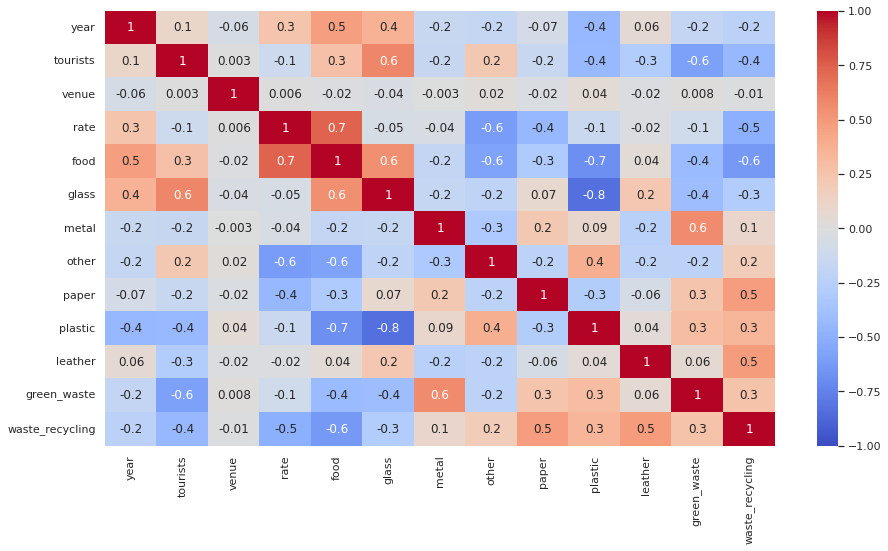

In [ ]:
sb.set(rc = {'figure.figsize':(15,8)})
sb.heatmap(concated.corr(), 
                fmt='.1g', 
                annot = True, 
                vmin=-1, 
                vmax=1, 
                center= 0, 
                cmap= 'coolwarm', 
                cbar=True
                )

Следующим шагом будет "дроп" сильно коррелирующих между собой фичей, чтобы они не так сильно влияли на обучение модели. Такими фичами являются колонки, как 'year','period', 'tourists', 'plastic', 'other', 'food', 'glass', 'green_waste', 'waste_recycling', 'metal', 'leather' и 'paper'.

In [164]:
concated = concated.drop([
    'Country',
    'year',
    'rate',
    'tourists',  
    'metal', 
    'plastic', 
    'leather', 
    'period', 
    'other', 
    'food', 
    'glass', 
    'green_waste', 
    'waste_recycling', 
    'paper',
    'venue'
    ], axis=1)

In [165]:
concated

,code,id
11,EEA_3161-03-3,FRGR0220
20,EEA_3161-05-5,FRDR179
27,EEA_3161-01-1,FRDR174
28,EEA_3161-05-5,FRDR174
33,EEA_3161-03-3,FRGR0173
...,...,...
19780,EEA_31615-01-7,ES020MSPF000000395
19824,EEA_3161-02-2,FRFR289B
19856,EEA_3161-01-1,FRDR2007E
19882,EEA_31615-01-7,UKSC006828


Далее сгенерируем списки числовых и категориальных колонок.

In [166]:
cat_col = [col_name for col_name in concated.columns if concated[col_name].dtypes == object]
num_col = [col_name for col_name in concated.columns if concated[col_name].dtypes != object]

cat_col, num_col, len(cat_col), len(num_col)

(['code', 'id'], [], 2, 0)

Для категориальных столбцов используем метод get_dummies() из импортированной библиотеки pandas. Это позволит превратить категориальные данные (которые непонятны для модели) в бинарные:

In [167]:
hotEncoded = pd.get_dummies(concated[cat_col])

In [114]:
hotEncoded

,code_EEA_3161-01-1,code_EEA_3161-02-2,code_EEA_3161-03-3,code_EEA_3161-05-5,code_EEA_31615-01-7,id_BERW06_AM17R,id_BERW06_EL18R,id_BERW06_EL19R,id_BERW06_HN05C,id_BERW06_LE14R,...,id_UKSC023282,id_UKSC023294,id_UKSC023295,id_UKSC023315,id_UKSC023319,id_UKSC023332,id_UKSC023345,id_UKSC023346,id_UKSC023347,id_UKSC023371
11,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19780,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19824,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19856,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19882,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Для числовых столбцов применим нормализацию из модуля preprocessing:

In [154]:
x = concated[num_col].values
min_max_scaler = preprocessing.MinMaxScaler()
norm = min_max_scaler.fit_transform(x)
norm = pd.DataFrame(norm, columns=num_col)
norm

ValueError: ignored

На этом этапе у нас есть два датафрейма: hotEncoded, содержащий бинарные данные и norm, содержащий нормализованные числовые данные. Чтобы объединить их воспользуемся методом .merge класса Dataframe. Слияние будет происходить на основе index:

In [131]:
hotEncoded['year']=concated['year']

In [116]:
concated = hotEncoded.merge(norm, on=hotEncoded.index)
concated

,key_0,code_EEA_3161-01-1,code_EEA_3161-02-2,code_EEA_3161-03-3,code_EEA_3161-05-5,code_EEA_31615-01-7,id_BERW06_AM17R,id_BERW06_EL18R,id_BERW06_EL19R,id_BERW06_HN05C,...,id_UKSC023295,id_UKSC023315,id_UKSC023319,id_UKSC023332,id_UKSC023345,id_UKSC023346,id_UKSC023347,id_UKSC023371,year,rate
0,11,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0
1,20,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0
2,27,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0
3,28,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0
4,33,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,19780,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.416667,1.0
3656,19824,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0
3657,19856,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0
3658,19882,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.333333,0.0


А затем дропнем колонку key_0, которая не несёт для нас никакой ценности и появляется в результате слияния двух датафреймов:

In [117]:
concated = concated.drop('key_0', axis=1)

После того, как обработали данные, нужно обратно разделить датафрейм concated на тестовый и тренировочный датарфеймы с тем же количеством строк, сколько содержалось в trainDF и testDF соответственно:

In [168]:
train = hotEncoded.iloc[0:trainDF.shape[0],:]
test = hotEncoded.iloc[trainDF.shape[0]:,:]

Проверим, всё ли правильно распределилось:

In [169]:
train.shape[0], trainDF.shape[0], test.shape[0], testDF.shape[0]

(2928, 2928, 732, 732)

Да, всё разделилось, как и нужно. Приступим к обучению модели.

# 3. Обучение модели и результирующее предсказание.

Разделим тренировочный датафрейм и наш таргет на тестовые и валидационные выборки классом train_test_split(),

In [170]:
X_train_, X_val, y_train_, y_val = train_test_split(train, target, test_size = 0.2, random_state = 42)

Создадим словарь params, в котором напишем название гиперпараметра и массив значений для перебора в GridSearchCV:

In [223]:
params = {
    'loss': ['hinge', 'log'],
    'learning_rate': ['adaptive', 'constant'],
    'eta0': np.linspace(0.05, 1, 10)
}


Присвоим переменной grid класс GridSearchCV со следующими параметрами:

1. модель SGDClassifier с примерно подобранными гипперпараметрами (функция потерь, штраф за неверный предикт, скорость обучения);
2. params, созданный ранее;
3. Оценка обучения (в нашем случае мы проверяем точность);
4. "Многословность".

GridSearchCV перебирает по-очереди значения params, и после вызова метода .best_params_ возвращает параметры, с которыми модель добилась высшей accuracy. Всего сетка перебирает len(params['max_iter']) * len(params['eta0']) * verbose значений.

In [224]:
grid = GridSearchCV(SGDClassifier(max_iter=2500), params, scoring='f1_macro', error_score='raise', verbose=10)
grid.fit(X_train_, y_train_.values.ravel())
grid.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START eta0=0.05, learning_rate=adaptive, loss=hinge..............
[CV 1/5; 1/40] END eta0=0.05, learning_rate=adaptive, loss=hinge;, score=0.811 total time=   1.3s
[CV 2/5; 1/40] START eta0=0.05, learning_rate=adaptive, loss=hinge..............
[CV 2/5; 1/40] END eta0=0.05, learning_rate=adaptive, loss=hinge;, score=0.778 total time=   0.8s
[CV 3/5; 1/40] START eta0=0.05, learning_rate=adaptive, loss=hinge..............
[CV 3/5; 1/40] END eta0=0.05, learning_rate=adaptive, loss=hinge;, score=0.785 total time=   0.8s
[CV 4/5; 1/40] START eta0=0.05, learning_rate=adaptive, loss=hinge..............
[CV 4/5; 1/40] END eta0=0.05, learning_rate=adaptive, loss=hinge;, score=0.789 total time=   0.8s
[CV 5/5; 1/40] START eta0=0.05, learning_rate=adaptive, loss=hinge..............
[CV 5/5; 1/40] END eta0=0.05, learning_rate=adaptive, loss=hinge;, score=0.780 total time=   0.7s
[CV 1/5; 2/40] START eta0=0.05, learning_ra

{'eta0': 0.5777777777777778, 'learning_rate': 'adaptive', 'loss': 'log'}

In [214]:
grid.best_score_

0.7913222685612906

Теперь дадим SGDClassifier полученные значения гиперпараметров, обучим её и сделаем предикт:

In [210]:
classifier = SGDClassifier(
    max_iter=1500, 
    loss='log'
    )

classifier.fit(X_train_, y_train_)
predict = classifier.predict(X_val)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Посмотрим среднеквадратическую ошибку и среднеквадратическое отклонение:

In [211]:
f1macro = f1_score(y_val, predict, average='macro')

f1macro

0.8048036465638149

Значения ошибки и отклонения не являются существенными, потому можем преступить к предсказанию на тестовом датафрейме:

In [58]:
pred = classifier.predict(test)

In [59]:
submission['polution_clf'] = pred

In [ ]:
submission

,polution_clf
idx,
19,0
46,1
94,1
96,1
98,1
...,...
19780,1
19824,1
19856,0


Сохраняем результат в csv-файл и загружаем его в каггл:

In [60]:
submission.to_csv('/content/Submission.csv',index=True)

In [61]:
!kaggle competitions submit -c urfu-engai-ml-2022-classification -f Submission.csv -m 'Final'

100% 5.30k/5.30k [00:00<00:00, 6.81kB/s]
Successfully submitted to UrFU_EngAI_ML_2022_Classification

Итоговая метрика: 0.83, т.е. совпадение предсказания и реальных значений около 83%.